In [1]:
import scipy.io as scio
import numpy as np
import pandas as pd

from keras import Sequential
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import KFold
from sklearn.metrics import *
from keras.models import Sequential,Model
from keras.layers import *

from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

import matplotlib.pyplot as plt
import seaborn as sns


Using TensorFlow backend.


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity ='all'

In [3]:
PATH ="D://DL_data/lz//"

In [4]:
data = scio.loadmat(PATH+'RHYTHMS.mat')

In [5]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'SR', 'VT', 'VF'])

In [6]:
#将。mat文件中的三物件数据分别存储到三个不同的变量中
SR_data = data['SR']
VT_data = data['VT']
VF_data = data['VF']

In [7]:
type(SR_data)
type(VT_data)
type(VF_data)

numpy.ndarray

numpy.ndarray

numpy.ndarray

In [8]:
#数据维度
SR_data.shape
VT_data.shape
VF_data.shape

(1, 488)

(1, 46)

(1, 60)

In [9]:
SR_data[0][0]
VT_data[0][0]
VF_data[0][0]

array([[ 29.42975058,  27.36808684],
       [ 29.37169797,  34.31769491],
       [ 28.99323827,  28.28577198],
       ...,
       [118.21177505, 169.03518084],
       [290.78267347, 118.58490454],
       [122.88673417, -54.74714758]])

array([[-21.67671125,   5.42781089],
       [-13.26543965,  11.74437439],
       [-10.57220052,  11.94258601],
       ...,
       [-30.51402258,   3.98168972],
       [-24.54658296,   9.72201618],
       [-25.24517226,   6.82009343]])

array([[-114.81119099,  -30.38372231],
       [-101.6909332 ,  -30.72394659],
       [ -74.3865354 ,  -25.8404295 ],
       ...,
       [  26.82129656,    4.93117365],
       [  24.09317195,    6.66421298],
       [  12.82659701,    9.36575575]])

In [10]:
len(SR_data[0])

488

In [11]:
SR_data[0][0][:,0]

array([ 29.42975058,  29.37169797,  28.99323827, ..., 118.21177505,
       290.78267347, 122.88673417])

In [12]:
def f(src):
    res = []
    for i in range(len(src[0])):
        res.append(src[0][i][:,0])
    return res

In [13]:
SR_test = []
VT_test = []
VF_test = []

In [14]:
#舍去频谱图当中的第一列（B列）
SR_test = f(SR_data)
VT_test = f(VT_data)
VF_test = f(VF_data)

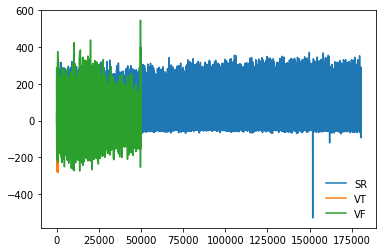

In [15]:
#初次尝试作图，发现数据长度不一样带来的数据高度密集
fig,ax = plt.subplots()
ax.plot(SR_test[0],label = 'SR')
ax.plot(VT_test[0],label = 'VT')
ax.plot(VF_test[0],label = 'VF')
ax.legend(loc='lower right', frameon=False)

<Figure size 1440x720 with 0 Axes>

(0, 800)

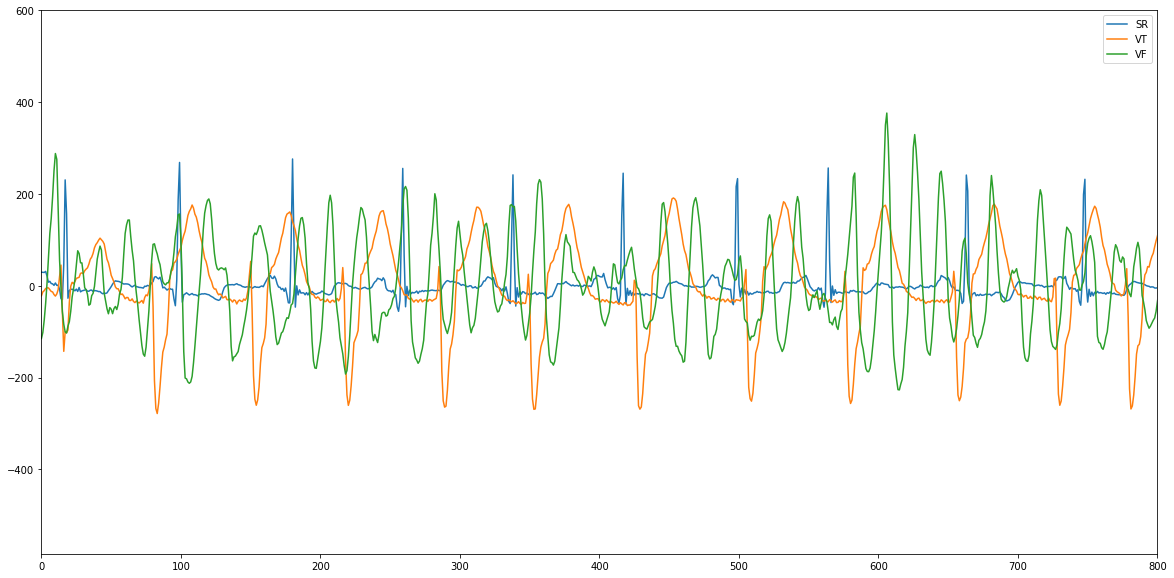

In [73]:
#可以大致看出每个种类的频谱具有不一样的特征
plt.figure(figsize=(20,10))
plt.xlim(0,800)
plt.plot(SR_test[100],label='SR')
plt.plot(VT_test[1],label='VT')
plt.plot(VF_test[20],label='VF')
plt.legend()

<Figure size 1440x720 with 0 Axes>

(0, 800)

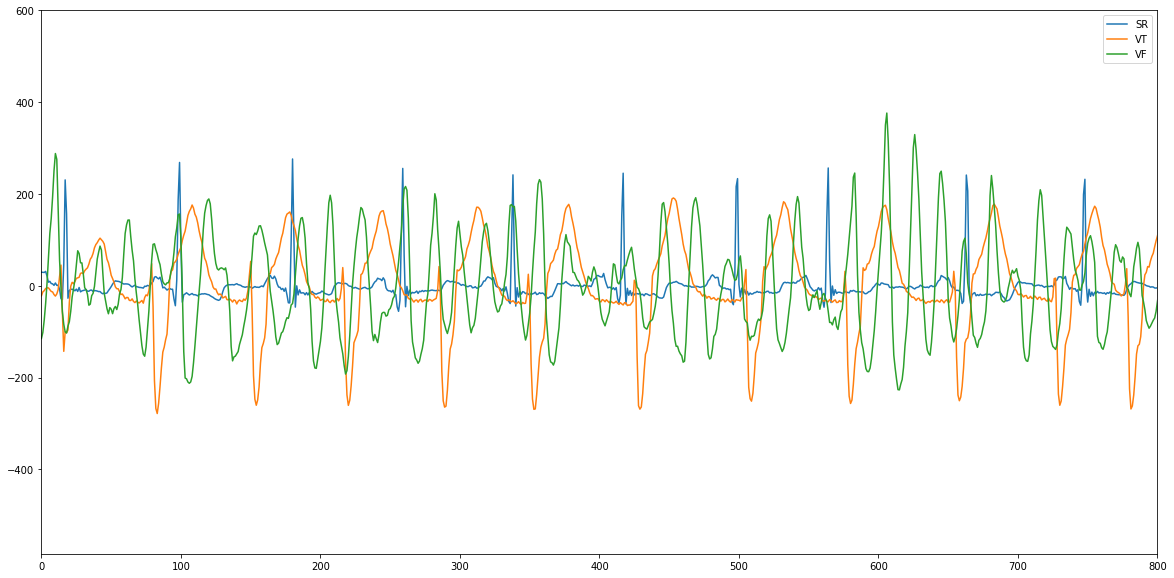

In [90]:
plt.figure(figsize=(20,10))
plt.xlim(0,800)
plt.plot(SR_test[0],label='SR')
plt.plot(VT_test[0],label='VT')
plt.plot(VF_test[0],label='VF')
plt.legend()

In [16]:
def show_len(data):
    res = []
    for i in range(len(data)):
        res.append(len(data[i]))
    return res

In [17]:
#长度显示：每个数据长度都不一样，所以不能从数据长度来判断物件种类
SR_len = show_len(SR_test)
VT_len = show_len(VT_test)
VF_len = show_len(VF_test)

In [18]:
SR = pd.DataFrame({'Signal':SR_test,'Classification':'SR'})
VT = pd.DataFrame({'Signal':VT_test,'Classification':'VT'})
VF = pd.DataFrame({'Signal':VF_test,'Classification':'VF'})

In [19]:
VF

,Signal,Classification
0,"[-114.81119098866763, -101.69093320453392, -74...",VF
1,"[12.826597008997549, 13.355284511573393, 7.215...",VF
2,"[-80.0124272629081, -86.78797729796932, -104.7...",VF
3,"[29.647250429222073, 32.51254305138988, 26.019...",VF
4,"[23.218166373620686, 18.632331215883315, 14.05...",VF
5,"[24.493514461854463, 16.002491240993066, 8.562...",VF
6,"[-12.123384328256547, 16.864564762581125, 31.2...",VF
7,"[-20.93338666082853, -28.8053184611498, -26.09...",VF
8,"[-37.22138524474476, -39.08668903217398, -41.5...",VF
9,"[6.361820509712498, 8.160367796777022, 10.7622...",VF


In [26]:
all_data = pd.concat([SR,VT,VF])

In [27]:
all_data

,Signal,Classification
0,"[29.42975058166, 29.37169797310235, 28.9932382...",SR
1,"[-8.887452260151282, -6.318858287707609, -4.24...",SR
2,"[12.790383577957149, 7.893029776621113, 8.0538...",SR
3,"[-3.836657273045951, -5.199758952374646, -4.43...",SR
4,"[-25.87328222407625, -21.18422677138712, -16.9...",SR
5,"[69.88652647369534, 101.4635148870283, 65.0005...",SR
6,"[72.21190031860417, 59.53650854336529, 55.1409...",SR
7,"[72.78028273100328, 69.30635382594558, 67.3578...",SR
8,"[4.862226746248392, 1.823196617050331, 6.43569...",SR
9,"[60.828292819390015, 62.79440962378961, 67.711...",SR


In [28]:
all_data = all_data.reset_index(drop=True)

In [29]:
all_data

,Signal,Classification
0,"[29.42975058166, 29.37169797310235, 28.9932382...",SR
1,"[-8.887452260151282, -6.318858287707609, -4.24...",SR
2,"[12.790383577957149, 7.893029776621113, 8.0538...",SR
3,"[-3.836657273045951, -5.199758952374646, -4.43...",SR
4,"[-25.87328222407625, -21.18422677138712, -16.9...",SR
5,"[69.88652647369534, 101.4635148870283, 65.0005...",SR
6,"[72.21190031860417, 59.53650854336529, 55.1409...",SR
7,"[72.78028273100328, 69.30635382594558, 67.3578...",SR
8,"[4.862226746248392, 1.823196617050331, 6.43569...",SR
9,"[60.828292819390015, 62.79440962378961, 67.711...",SR


In [30]:
from sklearn import preprocessing

In [31]:
le = preprocessing.LabelEncoder()

In [32]:
data = all_data.copy()

In [33]:
data['Classification'] = le.fit_transform(data['Classification'])

In [34]:
data.head()

,Signal,Classification
0,"[29.42975058166, 29.37169797310235, 28.9932382...",0
1,"[-8.887452260151282, -6.318858287707609, -4.24...",0
2,"[12.790383577957149, 7.893029776621113, 8.0538...",0
3,"[-3.836657273045951, -5.199758952374646, -4.43...",0
4,"[-25.87328222407625, -21.18422677138712, -16.9...",0


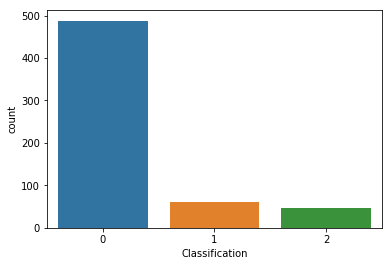

In [35]:
sns.countplot(x='Classification',data = data)

In [37]:
data['rnd'] = np.random.rand(len(data))
data = data.sort_values(by='rnd').drop('rnd',axis=1)

In [38]:
data.head()

,Signal,Classification
324,"[-19.5799973327928, -15.659430977719932, -22.9...",0
261,"[-3.4596590850917046, -6.539627682781742, -4.3...",0
443,"[34.05813009979163, 26.7860468084151, 23.76184...",0
315,"[-21.75635590064253, -25.68786235623249, -25.4...",0
427,"[-103.58194654305716, -88.96180962580473, -94....",0


In [43]:
l = 100000
for i in data['Signal']:
    if len(i)<l:
        l = len(i)

In [45]:
l

501

In [39]:
data.to_csv(PATH+'train.csv')

In [46]:
X = pad_sequences(data['Signal'], maxlen=500, padding='post')


In [47]:
X.shape

(594, 500)

In [50]:
y = data['Classification'].values

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [52]:
import tensorflow as tf

In [65]:
model2 = Sequential()
model2.add(BatchNormalization(input_shape=(564, 500)))
model2.add(Conv1D(64, 3, activation='relu'))
model2.add(Conv1D(16, 3, activation='relu'))
model2.add(Dense(1, activation=tf.nn.softmax))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_6 (Batch (None, 564, 500)          2000      
_________________________________________________________________
bidirectional_4 (Bidirection (None, 564, 20)           40880     
_________________________________________________________________
dense_6 (Dense)              (None, 564, 4)            84        
_________________________________________________________________
dropout_3 (Dropout)          (None, 564, 4)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 564, 1)            5         
Total params: 42,969
Trainable params: 41,969
Non-trainable params: 1,000
_________________________________________________________________
None


In [84]:
model3 = Sequential()
model3.add(Dense(16,input_shape=(500,),activation='relu'))
model1.add(Bidirectional(LSTM(8, dropout=0.4, recurrent_dropout=0.4, activation='relu', return_sequences=True)))
model3.add(Dropout(0.5))
model3.add(Dense(4,activation='relu'))
model3.add(Dense(1,activation='softmax'))
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 16)                8016      
_________________________________________________________________
dropout_12 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 5         
Total params: 8,089
Trainable params: 8,089
Non-trainable params: 0
_________________________________________________________________
None


In [86]:
model3.fit(x_train, y_train,validation_split=0.1, epochs=50)

Train on 507 samples, validate on 57 samples
Epoch 1/50
507/507 [==============================] - 1s 2ms/step - loss: nan - acc: 0.1026 - val_loss: nan - val_acc: 0.1053
Epoch 2/50
507/507 [==============================] - 0s 150us/step - loss: nan - acc: 0.1026 - val_loss: nan - val_acc: 0.1053
Epoch 3/50
507/507 [==============================] - 0s 155us/step - loss: nan - acc: 0.1026 - val_loss: nan - val_acc: 0.1053
Epoch 4/50
507/507 [==============================] - 0s 130us/step - loss: nan - acc: 0.1026 - val_loss: nan - val_acc: 0.1053
Epoch 5/50
507/507 [==============================] - 0s 138us/step - loss: nan - acc: 0.1026 - val_loss: nan - val_acc: 0.1053
Epoch 6/50
507/507 [==============================] - 0s 136us/step - loss: nan - acc: 0.1026 - val_loss: nan - val_acc: 0.1053
Epoch 7/50
507/507 [==============================] - 0s 126us/step - loss: nan - acc: 0.1026 - val_loss: nan - val_acc: 0.1053
Epoch 8/50
507/507 [==============================] - 0s 118u